# Hyperparameter Tuning of CBOW and Skipgram

In [49]:
try:
    import google.colab

    # Uninstall the current version of 'pyarrow', this is necessary to get ray running on colab
    !pip uninstall -y -q pyarrow
    
    # Install 'pyarrow' version 14.0.1
    !pip install pyarrow==14.0.1
    
    # Install the Ray package with Tune and Debug options
    !pip install -q -U ray[tune]
    !pip install -q ray[debug]
    
    # Force a crash to restart the environment (required for package changes to take effect)
    import os
    os._exit(0)

except:
    # If not in Google Colab or another error occurs, do nothing
    pass

In [50]:
import os

## Check if running on Google Colab
try:
    import google.colab
    in_colab = True  # Flag to indicate if running in Colab
    local_path = "/content/drive/MyDrive/DLSS/"  # Set the path to the desired directory on Google Drive
    google.colab.drive.mount('/content/drive')  # Mount Google Drive to access files

except ImportError:
    in_colab = False  # Flag to indicate if running locally
    current_wd = os.getcwd()  # Get the current working directory
    local_path = os.path.dirname(os.path.dirname(current_wd)) + "/"  # Set path to the main directory

print("CWD: ", local_path)  # Print the current working directory


## Import necessary libraries for data processing, modeling, and visualization
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Import Ray for distributed computing and hyperparameter tuning
import ray
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
import pickle

## Import metrics for model evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score

CWD:  c:\Users\wirth\OneDrive\Desktop/


In [ ]:
def filter_corpus(corpus, vocab_set):
    """
    Filters the corpus by keeping only the words that are present in the provided vocabulary set.

    Args:
        corpus (list of list of str): A list where each element is a list of words representing a document.
        vocab_set (set): A set containing the vocabulary words to be retained in the corpus.

    Returns:
        list of list of str: The filtered corpus with only words present in `vocab_set`.
    """
    # Iterate through each document in the corpus and retain only the words that are in vocab_set
    return [[word for word in doc if word in vocab_set] for doc in corpus]

In [ ]:
def create_context_target_pairs_cbow(text, context_size):
    """
    Creates context-target pairs for training a Continuous Bag of Words (CBOW) model.

    In a CBOW model, the context consists of words surrounding a target word, and the model 
    aims to predict the target word given its context.

    Args:
        text (list of list of str): A list of sentences, where each sentence is a list of words.
        context_size (int): The number of words to consider on each side of the target word for the context.

    Returns:
        list of tuple: A list of tuples where each tuple contains a context (list of words) and a target word (str).
    """
    pairs = []  # Initialize an empty list to store context-target pairs

    # Iterate over each sentence in the text
    for sentence in text:
        # Iterate over each word in the sentence, ignoring the edges where the full context can't be formed
        for i in range(context_size, len(sentence) - context_size):
            # Create the context by taking 'context_size' words before and after the target word
            context = sentence[i - context_size:i] + sentence[i + 1:i + context_size + 1]
            target = sentence[i]  # The target word is the current word in the sentence
            pairs.append((context, target))  # Append the context-target pair to the list

    return pairs  # Return the list of context-target pairs

In [ ]:
def create_context_target_pairs_skipgram(text, context_size):
    """
    Creates context-target pairs for training a Skip-gram model.

    In a Skip-gram model, the target word is used to predict the surrounding context words.

    Args:
        text (list of list of str): A list of sentences, where each sentence is a list of words.
        context_size (int): The number of words to consider on each side of the target word for the context.

    Returns:
        list of tuple: A list of tuples where each tuple contains a target word (str) and a context word (str).
    """
    pairs = []  # Initialize an empty list to store context-target pairs

    # Iterate over each sentence in the text
    for sentence in text:
        # Iterate over each word in the sentence
        for i in range(len(sentence)):
            target = sentence[i]  # The target word is the current word in the sentence

            # Define the context window, making sure it doesn't go out of sentence bounds
            context = sentence[max(0, i - context_size):i] + sentence[i + 1:i + context_size + 1]
            
            # Create a pair for each word in the context with the target word
            for ctx in context:
                pairs.append((target, ctx))  # Append the target-context pair to the list

    return pairs  # Return the list of target-context pairs

In [ ]:
class Word2VecDataset_cbow(Dataset):
    """
    PyTorch Dataset class for the CBOW (Continuous Bag of Words) model.

    This dataset prepares context-target pairs for training the CBOW model, where
    the context is a list of words and the target is a single word.

    Args:
        pairs (list of tuples): A list of context-target pairs where each context is a list of words and the target is a word.
        word_to_index (dict): A dictionary mapping words to their corresponding indices.

    Returns:
        context_idxs (torch.Tensor): A tensor of indices representing the context words.
        target_idx (torch.Tensor): A tensor representing the index of the target word.
    """
    def __init__(self, pairs, word_to_index):
        self.pairs = pairs  # Store the context-target pairs
        self.word_to_index = word_to_index  # Store the word-to-index mapping

    def __len__(self):
        return len(self.pairs)  # Return the number of pairs

    def __getitem__(self, idx):
        # Retrieve the context and target from the pairs at the given index
        context, target = self.pairs[idx]
        
        # Convert context words to indices using the word_to_index dictionary
        context_idxs = torch.tensor([self.word_to_index[word] for word in context], dtype=torch.long)
        
        # Convert target word to its index
        target_idx = torch.tensor(self.word_to_index[target], dtype=torch.long)
        
        return context_idxs, target_idx  # Return the context and target indices

In [ ]:
class Word2VecDataset_skipgram(Dataset):
    """
    PyTorch Dataset class for the Skip-gram model.

    This dataset prepares target-context pairs for training the Skip-gram model, where
    the target is a single word and the context is a single word.

    Args:
        pairs (list of tuples): A list of target-context pairs where each target and context is a word.
        word_to_index (dict): A dictionary mapping words to their corresponding indices.

    Returns:
        target_idx (torch.Tensor): A tensor representing the index of the target word.
        context_idx (torch.Tensor): A tensor representing the index of the context word.
    """
    def __init__(self, pairs, word_to_index):
        self.pairs = pairs  # Store the target-context pairs
        self.word_to_index = word_to_index  # Store the word-to-index mapping

    def __len__(self):
        return len(self.pairs)  # Return the number of pairs

    def __getitem__(self, idx):
        # Retrieve the target and context from the pairs at the given index
        target, context = self.pairs[idx]
        
        # Convert target word to its index
        target_idx = torch.tensor(self.word_to_index[target], dtype=torch.long)
        
        # Convert context word to its index
        context_idx = torch.tensor(self.word_to_index[context], dtype=torch.long)
        
        return target_idx, context_idx  # Return the target and context indices

In [ ]:
def prepare_data_for_model_training(file_name="str", min_count=int, data_sample_name=str):
    """
    Prepares data for training a word embedding model by loading, processing, and filtering the dataset.

    This function performs the following steps:
    1. Loads the data from a CSV file.
    2. Splits the data into training, validation, and test sets.
    3. Processes the text data into a corpus of words.
    4. Creates a vocabulary based on word frequency and filters out infrequent words.
    5. Maps words to indices and vice versa.
    6. Filters the corpus based on the created vocabulary.

    Args:
        file_name (str): The name of the CSV file containing the preprocessed comments (without extension).
        min_count (int): The minimum number of occurrences a word must have to be included in the vocabulary.
        data_sample_name (str): A label to identify the sample of data being processed.

    Returns:
        tuple: A tuple containing the filtered training, validation, and test corpora, 
               the word-to-index mapping, the index-to-word mapping, and the data sample name.
    """

    #### Parameters to choose:
    ## Load data from CSV file
    comments = pd.read_csv(local_path + f"/data/preprocessed/{file_name}.csv")

    # Splitting the data into train, validation, and test sets
    train_df, temp_df = train_test_split(comments, test_size=0.3, random_state=42)  # 70% train, 30% temp
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 50% val and 50% test

    # Combine all comments for generating the vocabulary to avoid missing tokens during training
    total_comments_list = comments["title_and_text_lemmatized"].dropna().astype(str).tolist()

    # Prepare lists for training, validation, and test sets
    train_list = train_df["title_and_text_lemmatized"].dropna().astype(str).tolist()
    val_list = val_df["title_and_text_lemmatized"].dropna().astype(str).tolist()
    test_list = test_df["title_and_text_lemmatized"].dropna().astype(str).tolist()

    # Convert sentences into lists of words (corpus)
    total_corpus = [doc.split() for doc in total_comments_list]
    corpus_train = [doc.split() for doc in train_list]
    corpus_val = [doc.split() for doc in val_list]
    corpus_test = [doc.split() for doc in test_list]

    # Create a vocabulary by counting occurrences of each word in the total corpus
    vocab = defaultdict(int)
    for sentence in total_corpus:
        for word in sentence:
            vocab[word] += 1

    # Remove infrequent words from the vocabulary
    vocab = {word: count for word, count in vocab.items() if count >= min_count}

    # Create word-to-index and index-to-word mappings
    word_to_index = {word: idx for idx, (word, _) in enumerate(vocab.items())}
    index_to_word = {idx: word for word, idx in word_to_index.items()}

    # Create DataFrame from vocabulary for potential analysis or inspection
    vocab_df = pd.DataFrame(list(vocab.items()), columns=['Word', 'Count'])

    # Create a set of vocabulary words for quick lookup
    vocab_set = set(vocab.keys())

    # Filter the corpus to include only words present in the vocabulary
    filtered_total_corpus = filter_corpus(total_corpus, vocab_set)
    filtered_corpus_train = filter_corpus(corpus_train, vocab_set)
    filtered_corpus_val = filter_corpus(corpus_val, vocab_set)
    filtered_corpus_test = filter_corpus(corpus_test, vocab_set)

    # Return the filtered corpora and the word mappings
    return filtered_corpus_train, filtered_corpus_val, filtered_corpus_test, word_to_index, index_to_word, data_sample_name

In [ ]:
class EarlyStopping:
    """
    Class that implements early stopping to halt training when the validation loss stops improving.

    Parameters:
    ----------
    patience : int
        Number of epochs to wait after the last improvement in validation loss before stopping the training.
    min_delta : float
        Minimum change in the validation loss to qualify as an improvement.

    Methods:
    ----------
    __call__(val_loss, model)
        Checks if the validation loss has improved and updates the state of early stopping.

    Attributes:
    ----------
    patience : int
        Number of epochs to wait after the last improvement in validation loss before stopping the training.
    min_delta : float
        Minimum change in the validation loss to qualify as an improvement.
    counter : int
        Counter for the number of epochs since the last improvement.
    best_loss : float or None
        Best recorded validation loss.
    early_stop : bool
        Indicating whether training should be stopped early.
    """

    def __init__(self, patience= int, min_delta= float):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss, model):
        ## for the first training iteration
        if self.best_loss is None:
            self.best_loss = val_loss
            ## check if the loss decreased, if not:
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            ## if loss decrease (more than the defined delta): save model parameters, reset counter and update best loss
        else:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.counter = 0

In [ ]:
def train_model_cbow(config, data):
    """
    Function that trains a model using the specified configuration and data, implements early stopping based on validation loss improvement, and reports training progress and results to Ray.

    Parameters:
    ----------
    config : dict
        Dictionary containing hyperparameters and settings for the model, training, and early stopping.
    data : tuple
        Tuple containing training and validation datasets.

    Returns:
    ----------
    dict
        A dictionary containing the final training loss, validation loss, accuracy, the epoch at which training stopped,
        and lists of validation and training losses across epochs.
    """


    filtered_corpus_train, filtered_corpus_val, word_to_index = data

    train_pairs = create_context_target_pairs_cbow(filtered_corpus_train, config["context_size"])
    val_pairs = create_context_target_pairs_cbow(filtered_corpus_val, config["context_size"])
    train_dataset = Word2VecDataset_cbow(train_pairs, word_to_index)
    val_dataset = Word2VecDataset_cbow(val_pairs, word_to_index)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, generator = torch.Generator().manual_seed(1234))
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)


    ## set seed to replicate the model
    torch.manual_seed(1234)

    ## empty lists to store loss
    train_losses = []
    val_losses = []

    ## initialise model
    model = CBOW(len(word_to_index), config["embedding_dim"]).to(device)

    ## loss criterion
    loss_criterion = nn.NLLLoss()

    ## choose optimiser
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    ## adapt learning rate with scheduler
    scheduler = StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    #### Early Stopper ####
    early_stopper = EarlyStopping(patience= config["patience"], min_delta = config["min_delta"])

    #### Training ####
    ## each epoch iterates through the whole dataset
    for epoch in range(config["epochs"]):
        ## train model on training set
        model.train()
        ## set loss and r2 to zero again so we start fresh
        train_loss = 0
        ## iterate through batches of the training data (data is the features and target the target)
        for context_idxs, target_idx in train_loader:
            ## send tensors to gpu
            context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
            ## reset gradient to 0,start fresh again
            optimizer.zero_grad()
            ## predict target
            log_probs = model(context_idxs)
            ## caculate loss
            loss = loss_criterion(log_probs, target_idx)
            ## caculate gradients
            loss.backward()
            ## update weights
            optimizer.step()
            ## sum loss for all batches together
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))



        #### Validation ####
        ## check performance on validation set
        model.eval()
        ## set loss to zero again so we start fresh
        val_loss_sum = 0
        total = 0
        correct = 0

        ## as we test on the validation set, we do not want to update our weights now
        with torch.no_grad():
            for context_idxs, target_idx in val_loader:
                ## send tensors to gpu
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                log_probs = model(context_idxs)
                ## caculate loss
                loss = loss_criterion(log_probs, target_idx)
                ## sum loss for whole epoch
                val_loss_sum += loss.item()

                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                correct += (predicted_idx == target_idx).sum().item()
                total += context_idxs.size(0)

        val_loss = val_loss_sum / len(val_loader)
        accuracy = correct / total
        val_losses.append(val_loss)

        ## adapt learning rate
        scheduler.step()

        ## save checkpoints only if loss decreased and the epoch is larger than the patience (to save less checkpoints) but always report metrics to ray
        if epoch > 0 and early_stopper.best_loss - config["min_delta"]  > val_loss:
          ##save checkpoint
          torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")

          ## report mertrics and save checkpoint
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      },
                  checkpoint=Checkpoint.from_directory(".")
                  )
        else:
          ##report only metrics
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      }
                  )

        #### Early stopping ####
        # check if loss decreases more than defined threshold
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            break

    ## last checkpoint
    torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")
    ray.train.report(
        {"loss": round(early_stopper.best_loss, 3), "epoch": int(epoch), "accuracy": round(accuracy, 3)},
        checkpoint=Checkpoint.from_directory(".")
        )

    #return train_losses, val_losses, val_r2s
    return {
        "loss": round(early_stopper.best_loss, 2),
        "accuracy": accuracy,
        "val_loss_list": val_losses,
        "train_loss_list": train_losses
        }

In [ ]:
def train_model_skipgram(config, data):
    """
    Function that trains a model using the specified configuration and data, implements early stopping based on validation loss improvement, and reports training progress and results to Ray.

    Parameters:
    ----------
    config : dict
        Dictionary containing hyperparameters and settings for the model, training, and early stopping.
    data : tuple
        Tuple containing training and validation datasets.

    Returns:
    ----------
    dict
        A dictionary containing the final training loss, validation loss, accuracy, the epoch at which training stopped,
        and lists of validation and training losses across epochs.
    """


    filtered_corpus_train, filtered_corpus_val, word_to_index = data

    train_pairs = create_context_target_pairs_skipgram(filtered_corpus_train, config["context_size"])
    val_pairs = create_context_target_pairs_skipgram(filtered_corpus_val, config["context_size"])
    train_dataset = Word2VecDataset_skipgram(train_pairs, word_to_index)
    val_dataset = Word2VecDataset_skipgram(val_pairs, word_to_index)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, generator = torch.Generator().manual_seed(1234))
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)


    ## set seed to replicate the model
    torch.manual_seed(1234)

    ## empty lists to store loss
    train_losses = []
    val_losses = []

    ## initialise model
    model = SkipGram(len(word_to_index), config["embedding_dim"]).to(device)

    ## loss criterion
    loss_criterion = nn.NLLLoss()

    ## choose optimiser
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    ## adapt learning rate with scheduler
    scheduler = StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    #### Early Stopper ####
    early_stopper = EarlyStopping(patience= config["patience"], min_delta = config["min_delta"])

    #### Training ####
    ## each epoch iterates through the whole dataset
    for epoch in range(config["epochs"]):
        ## train model on training set
        model.train()
        ## set loss and r2 to zero again so we start fresh
        train_loss = 0
        ## iterate through batches of the training data (data is the features and target the target)
        for context_idxs, target_idx in train_loader:
            ## send tensors to gpu
            context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
            ## reset gradient to 0,start fresh again
            optimizer.zero_grad()
            ## predict target
            log_probs = model(target_idx)
            ## caculate loss
            loss = loss_criterion(log_probs, context_idxs)
            ## caculate gradients
            loss.backward()
            ## update weights
            optimizer.step()
            ## sum loss for all batches together
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))



        #### Validation ####
        ## check performance on validation set
        model.eval()
        ## set loss to zero again so we start fresh
        val_loss_sum = 0
        total = 0
        correct = 0

        ## as we test on the validation set, we do not want to update our weights now
        with torch.no_grad():
            for context_idxs, target_idx in val_loader:
                ## send tensors to gpu
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                log_probs = model(target_idx)
                ## caculate loss
                loss = loss_criterion(log_probs, context_idxs)
                ## sum loss for whole epoch
                val_loss_sum += loss.item()

                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                correct += (predicted_idx == context_idxs).sum().item()
                total += context_idxs.size(0)

        val_loss = val_loss_sum / len(val_loader)
        accuracy = correct / total
        val_losses.append(val_loss)

        ## adapt learning rate
        scheduler.step()

        ## save checkpoints only if loss decreased and the epoch is larger than the patience (to save less checkpoints) but always report metrics to ray
        if epoch > 0 and early_stopper.best_loss - config["min_delta"]  > val_loss:
          ##save checkpoint
          torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")

          ## report mertrics and save checkpoint
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      },
                  checkpoint=Checkpoint.from_directory(".")
                  )
        else:
          ##report only metrics
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      }
                  )

        #### Early stopping ####
        # check if loss decreases more than defined threshold
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            break

    ## last checkpoint
    torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")
    ray.train.report(
        {"loss": round(early_stopper.best_loss, 3), "epoch": int(epoch), "accuracy": round(accuracy, 3)},
        checkpoint=Checkpoint.from_directory(".")
        )

    #return train_losses, val_losses, val_r2s
    return {
        "loss": round(early_stopper.best_loss, 2),
        "accuracy": accuracy,
        "val_loss_list": val_losses,
        "train_loss_list": train_losses
        }

In [ ]:
#### Tuning ####
## Custom function to shorten ray file path names
def short_dirname(trial) -> str:
    """
    Function that shortens path names created by Ray.

    Parameters:
    ----------
    trial : ray.tune.Trial
        The Ray trial object for which the directory name is being created.

    Return:
    ----------
    str
        A shortened file path in the format 'trial_<trial_id>'.
    """
    return "trial_" + str(trial.trial_id)

In [ ]:
def tune_parameters(training_function, num_samples, train_corpus, val_corpus, word_to_index, max_num_epochs, parameter_space, resources, local_path):
    """
    Function that tunes the hyperparameters for a DL model using ASHA scheduling and saves the best model and tuning results locally.

    Parameters:
    ----------
    training_function : function
        The function used for training the model during hyperparameter tuning.
    num_samples : int
        The number of hyperparameter samples to try.
    train_dataset : object
        Training dataset object.
    val_dataset : object
        Validation dataset object.
    max_num_epochs : int
        The maximum number of epochs for training each model.
    parameter_space : dict
        Dictionary defining the hyperparameter search space.
    resources : dict
        Resources configuration for training.
    local_path : str
        Local path to save tuning results and best model.

    Returns:
    ----------
    pandas.DataFrame
        DataFrame containing the tuning results, sorted by loss.
        """

    ## because min number of epochs in sampling range is 50
    #assert max_num_epochs > 50

    ## Hyperparameters to sample from
    ## ASHA scheduler to increase efficiency and stop inefficient training configs
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2
    )

    ## tuning function, choose resources
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(
                training_function,
                data = (train_corpus, val_corpus, word_to_index)),
                resources= resources
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=short_dirname
        ),
        param_space= parameter_space,
        run_config = ray.train.RunConfig(storage_path = local_path, name="run_" + datetime.now().strftime("%m-%d_%H_%M"))
    )

    results = tuner.fit()


    #### Best Model ####

    ## create folder
    os.makedirs(local_path + f'/best_models_{parameter_space["data_sample_name"]}', exist_ok=True)

    ## get best model
    best_result = results.get_best_result("loss", "min")

    ## save info about best model
    with open(local_path + f'/best_models_{parameter_space["data_sample_name"]}/best_result_info_' + parameter_space["model"] + '.pkl', 'wb') as file:
        pickle.dump(best_result, file)



    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))

    ## get path to that best model
    best_checkpoint_path = best_result.get_best_checkpoint(metric = "loss", mode = "min").path + "/checkpoint_"+ parameter_space["model"] + ".pt"
    ## save path to model as txt
    #with open(local_path + f"/best_models_{parameter_space["folder_ending"]}//path_best_model_" + parameter_space["model"] + ".txt", "w") as file:
    #    file.write(best_checkpoint_path)

    ##save model parameters
    best_checkpoint = torch.load(best_checkpoint_path)

    ## create new model
    if parameter_space["model"] == "CBOW":
        model_final = CBOW(
            vocab_size = len(word_to_index),
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )
    else:
        model_final = SkipGram(
            vocab_size = len(word_to_index),
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )



    ## load parameteres of best checkpoint
    model_final.load_state_dict(best_checkpoint)

    torch.save(model_final.state_dict(), local_path + f'/best_models_{parameter_space["data_sample_name"]}/best_model_parameters_' + parameter_space["model"] + '.pt')

    #### Tuning Overview ####
    ## Get results as df
    df_tuning_results = results.get_dataframe()
    ## Rename cols
    df_tuning_results.columns = [col.replace('config/', '') for col in df_tuning_results.columns]
    ## sort by loss
    df_tuning_results.sort_values("loss", inplace = True)
    ## Save only relevant cols
    df_tuning_results = df_tuning_results[['loss', "accuracy", "context_size", 'lr', 'batch_size', 'epochs',
                                           'patience', 'min_delta', "gamma", "step_size",
                                           "dropout", 'time_total_s', "val_loss_list", "train_loss_list"]]
    ## Save as csv
    df_tuning_results.to_csv(local_path + f'/best_models_{parameter_space["data_sample_name"]}/df_tuning_results' + parameter_space["model"] + '.csv')

    return df_tuning_results

In [ ]:
 #### Replication ####
def load_best_model(model_type = str, local_path = str, data_sample_name = str):
    """
    Function that loads the best model based on the specified model type.

    Parameters:
    ----------
    model_type : str
        Type of the model to load ("CNN" or other).

    Return:
    ----------
    torch.nn.Module
        The best pre-trained model loaded on the device and ready for evaluation.
    """

    ## get best config
    with open(f'{local_path}/tuning_results/best_models_{data_sample_name}/best_result_info_{model_type}.pkl', 'rb') as file:
    # Use pickle.dump() to write the data object to file
        best_result = pickle.load(file)

    #with open(f"{local_path}/tuning_results/best_models/path_best_model_{model_type}.txt") as file:
    #    path_best_file = file.read()

    ## load parameters of best model
    best_checkpoint = torch.load(f'{local_path}/tuning_results/best_models_{data_sample_name}/best_model_parameters_{model_type}.pt')

    ## create new model
    if model_type == "CBOW":
        model_final = CBOW(
            vocab_size = len(word_to_index),
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )
    else:
        model_final = SkipGram(
            vocab_size = len(word_to_index),
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )



    ## load parameteres of best checkpoint
    model_final.load_state_dict(best_checkpoint)
    ## model into evaluation mode
    model_final.eval()
    model_final.to(device)

    return model_final

In [ ]:
def plot_loss_curve(model_type = str, local_path = str, data_sample_name = str):

   """
    Function that plots the training and validation loss curves of the best model.

    Parameters:
    ----------
    model_type : str
        Type of the model whose loss curve to plot ("CNN" or other).

    Return:
    ----------
    None
    """

   ## get file with loss data
   with open(local_path + f"/tuning_results/best_models_{data_sample_name}/best_result_info_{model_type}.pkl", 'rb') as file:
       best_result = pickle.load(file)

   ## get respective tuning data
   val_losses = best_result.metrics["val_loss_list"]
   ## i forgot to divide the train loss by n in the training function
   ## and repeating that takes 8 hours, so I have to do it like this now
   train_losses = best_result.metrics["train_loss_list"]

   ## create plot
   plt.plot(train_losses, label='Training Loss')
   plt.plot(val_losses, label='Validation Loss')
   plt.title(f"{model_type} loss curves")
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.legend()
   ## save
   plt.savefig(local_path + f"plots/loss_curve_{model_type}_{data_sample_name}.png")
   plt.show()

In [ ]:
def classify(model_type, dataloader, index_to_word, data_sample_name=str, include_true_vals=True):
    """
    Classifies words using a trained CBOW or Skip-gram model and returns the predicted words.

    This function performs the following steps:
    1. Loads the best trained model based on the provided model type and data sample name.
    2. Iterates through the provided data using a DataLoader.
    3. For each batch, predicts the target word(s) based on the context (for CBOW) or predicts the context word(s) based on the target (for Skip-gram).
    4. Optionally, returns the true values along with the predictions.

    Args:
        model_type (str): The type of the model used ('CBOW' or 'Skip-gram').
        dataloader (torch.utils.data.DataLoader): DataLoader object that provides batches of data for classification.
        index_to_word (dict): A dictionary mapping indices to words.
        data_sample_name (str): The name of the data sample used for loading the model.
        include_true_vals (bool): Whether to return the true target/context values along with predictions.

    Returns:
        If include_true_vals is True:
            tuple: Two lists containing predicted words and true words.
        If include_true_vals is False:
            list: A list of predicted words.
    """

    # Load the best trained model based on the model type and data sample name
    model = load_best_model(model_type, local_path=local_path, data_sample_name=data_sample_name)

    predictions, true_vals = [], []  # Initialize lists to store predictions and true values

    with torch.no_grad():
        # Iterate through the dataloader to get batches of data
        for context_idx, target_idx in dataloader:
            # Move data to the appropriate device (CPU or GPU)
            context_idx, target_idx = context_idx.to(device), target_idx.to(device)
            
            # For CBOW, predict the target word based on the context
            if model_type == "CBOW":
                log_probs = model(context_idx)
            else:  # For Skip-gram, predict the context word based on the target
                log_probs = model(target_idx)

            # Get the index of the word with the highest log-probability (the predicted word)
            _, predicted_idx = torch.max(log_probs, dim=1)
            
            # Convert the predicted indices to words and add them to the predictions list
            predictions.extend([index_to_word.get(word_id.item()) for word_id in predicted_idx.cpu().numpy()])

            if include_true_vals:
                # Convert the true indices to words and add them to the true_vals list
                if model_type == "CBOW":
                    true_vals.extend([index_to_word.get(word_id.item()) for word_id in target_idx.cpu().numpy()])
                else:
                    true_vals.extend([index_to_word.get(word_id.item()) for word_id in context_idx.cpu().numpy()])

    # Return predictions and true values if requested
    if include_true_vals:
        return predictions, true_vals
    else:
        return predictions

In [ ]:
def evaluate_classification(model_type, prediction_val, prediction_test, y_val, y_test):
    """
    Function that evaluates a classification model by computing accuracy, recall, precision, and F-score for the training and validation data, and optionally for the test dataset.

    Parameters:
    ----------
    model_type : str
        Type of the model being evaluated.
    prediction_val : array
        Predictions made by the model on the validation dataset.
    prediction_test : array
        Predictions made by the model on the test dataset.
    y_val : array
        Actual target values in the validation dataset.
    y_test : array
        Actual target values in the test dataset.
    final_testing : bool, default=False
        Flag indicating whether to evaluate the model on the test dataset.

    Return:
    ----------
    None
    """
    print(f"\n--------------------------\n{model_type} Classification Evaluation \n--------------------------")


    print("\nValidation set")
    print("--------------")

    print(f"F1 Score: {f1_score(y_true = y_val, y_pred = prediction_val, average = 'micro'):.2f}")
    print(f"Accuracy: {accuracy_score(y_true = y_val, y_pred = prediction_val):.2f}")

    #print(classification_report(y_true = y_val, y_pred = prediction_val, digits=2, zero_division=0))
    print("\nTest set")
    print("--------\n")
    print(f"F1 Score: {f1_score(y_true = y_test, y_pred = prediction_test, average = 'micro'):.2f}")
    print(f"Accuracy: {accuracy_score(y_true = y_test, y_pred = prediction_test):.2f}")

    #print(classification_report(y_true = y_test, y_pred = prediction_test, digits=2, zero_division=0))

In [ ]:
def extract_embeddings(model_type=str, local_path=str, data_sample_name=str, index_to_word=dict):
    """
    Extracts word embeddings from a trained model and saves them to a CSV file.

    This function performs the following steps:
    1. Loads the best trained model based on the provided model type and data sample name.
    2. Extracts the word embeddings from the model.
    3. Creates a DataFrame containing the embeddings with their corresponding words.
    4. Saves the embeddings to a CSV file.

    Args:
        model_type (str): The type of the model used (e.g., 'cbow', 'skipgram').
        local_path (str): The local directory path where the model and embeddings are stored.
        data_sample_name (str): The name of the data sample used for training the model.
        index_to_word (dict): A dictionary mapping indices to words.

    Returns:
        embeddings_df (pd.DataFrame): A DataFrame containing the word embeddings with words as the first column.
    """

    # Load the best trained model based on model type and data sample name
    model = load_best_model(model_type=model_type, local_path=local_path, data_sample_name=data_sample_name)
    
    # Extract the embeddings from the model as a NumPy array
    embeddings = model.embeddings.weight.detach().cpu().numpy()

    # Create a DataFrame from the embeddings
    embeddings_df = pd.DataFrame(embeddings)
    
    # Insert a column with the corresponding words
    embeddings_df.insert(0, 'word', [index_to_word[i] for i in range(len(embeddings_df))])
    
    # Save the embeddings DataFrame to a CSV file
    embeddings_df.to_csv(local_path + f"data/embeddings/embeddings_{model_type}_{data_sample_name}.csv")
    
    return embeddings_df  # Return the embeddings DataFrame

In [52]:
#### Continuous bag of words model #####
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # Embedding layer for word indices
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Linear layer for mapping embeddings to vocab size
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, context):
        # Get embeddings for context words
        embeds = self.embeddings(context)
        # Average embeddings to get a single vector
        combined = torch.mean(embeds, dim=1)
        # Apply dropout and pass through linear layer
        out = self.linear1(self.dropout(combined))
        # Compute log probabilities
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        # Define an embedding layer that will learn word representations
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Define a linear layer that maps from the embedding space to the vocabulary space
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        # Define a dropout layer to prevent overfitting during training
        self.dropout = nn.Dropout(0.5)

    def forward(self, target):
        # Get the embeddings for the target words
        embeds = self.embeddings(target)
        # Apply dropout to the embeddings and pass them through the linear layer
        out = self.linear1(self.dropout(embeds))
        # Apply log softmax to the output to get log-probabilities over the vocabulary
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs  # Return the log-probabilities

In [53]:
# Prepare data for model training
filtered_corpus_train, filtered_corpus_val, filtered_corpus_test, word_to_index, index_to_word, data_sample_name = prepare_data_for_model_training(
    file_name = "total_posts", # train on total_posts
    min_count = 40, # set min_count to 40 to reduce vocab size
    data_sample_name = "total_posts")

In [54]:
# Define the sample size and the maximum number of epochs for training
n_samples = 6  # Number of samples to use for tuning (can be adjusted based on needs)
epochs = 80  # Maximum number of epochs for training

# Define the computational resources to allocate for the tuning process
resources = {"cpu": 24, "gpu": 1}  # Number of CPUs and GPUs to use

# Set the device to GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used (either 'cuda' for GPU or 'cpu')

cuda


(train_model_cbow pid=48784) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/wirth/OneDrive/Desktop/tuning_results/run_08-22_00_23/trial_00f84_00000/checkpoint_000000)
(train_model_cbow pid=48784) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/wirth/OneDrive/Desktop/tuning_results/run_08-22_00_23/trial_00f84_00000/checkpoint_000001)
(train_model_cbow pid=48784) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/wirth/OneDrive/Desktop/tuning_results/run_08-22_00_23/trial_00f84_00000/checkpoint_000002)
(train_model_cbow pid=48784) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/wirth/OneDrive/Desktop/tuning_results/run_08-22_00_23/trial_00f84_00000/checkpoint_000003)
(train_model_cbow pid=48784) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/wirth/OneDrive/Desktop/tuning_results/run_08-22_00_23/trial_00f84_00000/checkpoint_000004)
(trai

Best trial config: {'model': 'CBOW', 'data_sample_name': 'total_posts', 'context_size': 2, 'dropout': 0.5, 'lr': 0.0028228658248271535, 'batch_size': 512, 'epochs': 60, 'patience': 15, 'min_delta': 0.0036075632797252636, 'gamma': 0.9, 'step_size': 10, 'weight_decay': 0.00017490364688456408, 'embedding_dim': 1000}
Best trial final validation loss: 5.86


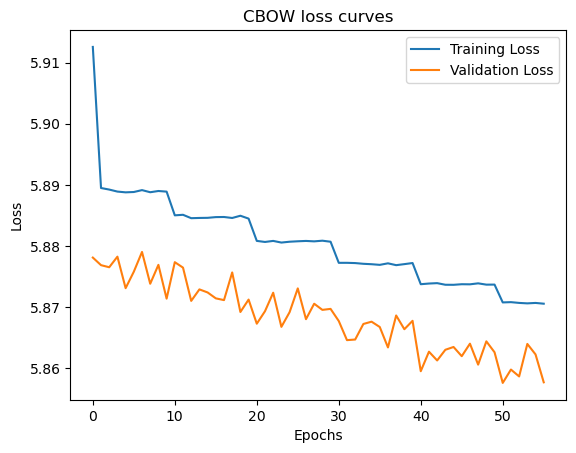

C:\Users\wirth\AppData\Local\Temp\ipykernel_37088\3456389537.py:642: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(f'{local_path}/tuning_results

In [56]:
## Clear GPU memory to ensure no residual memory is being used from previous operations
torch.cuda.empty_cache()

## Perform hyperparameter tuning
tune_parameters(
    train_model_cbow,  # Function to train the CBOW model
    num_samples=n_samples,  # Number of hyperparameter configurations to try
    train_corpus=filtered_corpus_train,  # Training corpus to use for model training
    val_corpus=filtered_corpus_val,  # Validation corpus to use for evaluating model performance
    word_to_index=word_to_index,  # Dictionary mapping words to their corresponding indices
    max_num_epochs=epochs,  # Maximum number of epochs for each hyperparameter configuration
    resources=resources,  # Computational resources to allocate (CPU/GPU)
    
    # Define the hyperparameter space to explore during tuning
    parameter_space={
        "model": "CBOW",  # Type of model being tuned
        "data_sample_name": data_sample_name,  # Name of the data sample
        "context_size": tune.choice([2, 3, 4, 5]),  # Different context sizes to try
        "dropout": tune.choice([0.1, 0.2, 0.3, 0.4, 0.5]),  # Dropout rates to prevent overfitting
        "lr": tune.loguniform(1e-4, 1e-2),  # Learning rate sampled logarithmically between 1e-4 and 1e-2
        "batch_size": tune.choice([64, 128, 256, 512, 1024]),  # Different batch sizes to try
        "epochs": tune.choice(list(range(50, 150, 10))),  # Number of epochs, ranging from 50 to 140 in steps of 10
        "patience": tune.choice([5, 10, 15]),  # Early stopping patience values to try
        "min_delta": tune.loguniform(0.01, 0.0001),  # Minimum change to qualify as an improvement for early stopping
        "gamma": tune.choice([0.1, 0.25, 0.5, 0.75, 0.9]),  # Different values for the learning rate decay factor
        "step_size": tune.choice([5, 10, 20]),  # Step sizes for learning rate scheduler
        "weight_decay": tune.loguniform(1e-4, 1e-2),  # Weight decay (L2 regularization) values to try
        "embedding_dim": tune.choice([100, 500, 1000])  # Different embedding dimensions to try
    },
    
    local_path=local_path + "/tuning_results"  # Path where the tuning results will be saved
)

# Plot the loss curve for the CBOW model based on the tuning results
plot_loss_curve("CBOW", local_path=local_path, data_sample_name=data_sample_name)

# Extract and save the embeddings from the best CBOW model
embeddings_cbow_all_years = extract_embeddings(
    model_type="CBOW",  # Specify the type of model used (CBOW)
    local_path=local_path,  # Path where the model and embeddings are stored
    data_sample_name=data_sample_name,  # Name of the data sample
    index_to_word=index_to_word  # Dictionary mapping indices back to words
)

In [58]:
# Set the context size for the CBOW model
context_size = 2

# Generate context-target pairs for the validation and test datasets using the CBOW model
val_pairs_cbow = create_context_target_pairs_cbow(filtered_corpus_val, context_size)
test_pairs_cbow = create_context_target_pairs_cbow(filtered_corpus_test, context_size)

# Create datasets for validation and test data using the generated pairs
val_dataset_cbow = Word2VecDataset_cbow(val_pairs_cbow, word_to_index)
test_dataset_cbow = Word2VecDataset_cbow(test_pairs_cbow, word_to_index)

# Create DataLoaders for the validation and test datasets
# Batch size is set to the length of the dataset to process the entire dataset at once
val_loader_cbow = DataLoader(val_dataset_cbow, batch_size=len(val_dataset_cbow), shuffle=False)
test_loader_cbow = DataLoader(test_dataset_cbow, batch_size=len(test_dataset_cbow), shuffle=False)

# Perform classification on the validation data using the CBOW model
prediction_val_cbow, true_val_cbow = classify(
    model_type="CBOW",
    dataloader=val_loader_cbow,
    index_to_word=index_to_word,
    data_sample_name=data_sample_name
)

# Perform classification on the test data using the CBOW model
prediction_test_cbow, true_test_cbow = classify(
    model_type="CBOW",
    dataloader=test_loader_cbow,
    index_to_word=index_to_word,
    data_sample_name=data_sample_name
)

# Evaluate the classification results by comparing predictions to the true values
evaluate_classification(
    model_type="CBOW",
    prediction_val=prediction_val_cbow,
    prediction_test=prediction_test_cbow,
    y_val=true_val_cbow,
    y_test=true_test_cbow
)

C:\Users\wirth\AppData\Local\Temp\ipykernel_37088\3456389537.py:642: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(f'{local_path}/tuning_results

OutOfMemoryError: CUDA out of memory. Tried to allocate 29.89 GiB. GPU 0 has a total capacity of 15.99 GiB of which 14.42 GiB is free. Of the allocated memory 307.82 MiB is allocated by PyTorch, and 14.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Skipgram

In [ ]:
## Clear GPU memory to ensure no residual memory is being used from previous operations
torch.cuda.empty_cache()

## Perform hyperparameter tuning for the Skip-gram model
tune_parameters(
    train_model_skipgram,  # Function to train the Skip-gram model
    num_samples=n_samples,  # Number of hyperparameter configurations to try
    train_corpus=filtered_corpus_train,  # Training corpus to use for model training
    val_corpus=filtered_corpus_val,  # Validation corpus to use for evaluating model performance
    word_to_index=word_to_index,  # Dictionary mapping words to their corresponding indices
    max_num_epochs=epochs,  # Maximum number of epochs for each hyperparameter configuration
    resources=resources,  # Computational resources to allocate (CPU/GPU)
    
    # Define the hyperparameter space to explore during tuning
    parameter_space={
        "model": "skipgram",  # Specify the model type as Skip-gram
        "data_sample_name": data_sample_name,  # Name of the data sample
        "context_size": tune.choice([2, 3, 4, 5]),  # Different context sizes to try
        "dropout": tune.choice([0.1, 0.2, 0.3, 0.4, 0.5]),  # Dropout rates to prevent overfitting
        "lr": tune.loguniform(1e-4, 1e-2),  # Learning rate sampled logarithmically between 1e-4 and 1e-2
        "batch_size": tune.choice([64, 128, 256, 512, 1024]),  # Different batch sizes to try
        "epochs": tune.choice(list(range(50, 150, 10))),  # Number of epochs, ranging from 50 to 140 in steps of 10
        "patience": tune.choice([5, 10, 15]),  # Early stopping patience values to try
        "min_delta": tune.loguniform(0.01, 0.0001),  # Minimum change to qualify as an improvement for early stopping
        "gamma": tune.choice([0.1, 0.25, 0.5, 0.75, 0.9]),  # Different values for the learning rate decay factor
        "step_size": tune.choice([5, 10, 20]),  # Step sizes for learning rate scheduler
        "weight_decay": tune.loguniform(1e-4, 1e-2),  # Weight decay (L2 regularization) values to try
        "embedding_dim": tune.choice([100, 500, 1000])  # Different embedding dimensions to try
    },
    
    local_path=local_path + "/tuning_results"  # Path where the tuning results will be saved
)

# Plot the loss curve for the Skip-gram model based on the tuning results
plot_loss_curve("skipgram", local_path=local_path, data_sample_name=data_sample_name)

# Extract and save the embeddings from the best Skip-gram model
embeddings_skipgram_all_years = extract_embeddings(
    model_type="skipgram",  # Specify the type of model used (Skip-gram)
    local_path=local_path,  # Path where the model and embeddings are stored
    data_sample_name=data_sample_name,  # Name of the data sample
    index_to_word=index_to_word  # Dictionary mapping indices back to words
)

In [ ]:
# Set the context size for the CBOW model
context_size = 2

# Generate context-target pairs for the validation and test datasets using the skipigram model
val_pairs_skipgram = create_context_target_pairs_skipgram(filtered_corpus_val, context_size)
test_pairs_skipgram = create_context_target_pairs_skipgram(filtered_corpus_test, context_size)

# Create datasets for validation and test data using the generated pairs
val_dataset_skipgram = Word2VecDataset_skipgram(val_pairs_skipgram, word_to_index)
test_dataset_skipgram = Word2VecDataset_skipgram(test_pairs_skipgram, word_to_index)

# Create DataLoaders for the validation and test datasets
# Batch size is set to the length of the dataset to process the entire dataset at once
val_loader_skipgram = DataLoader(val_dataset_skipgram, batch_size=len(val_dataset_cbow), shuffle=False)
test_loader_skipgram = DataLoader(test_dataset_skipgram, batch_size=len(test_dataset_skipgram), shuffle=False)

# Perform classification on the validation data using the skipgram model
prediction_val_skipgram, true_val_skipgram = classify(
    model_type="skipgram",
    dataloader = val_loader_skipgram,
    index_to_word=index_to_word,
    data_sample_name = data_sample_name
    )

# Perform classification on the test data using the skipgram model
prediction_test_skipgram, true_test_skipgram = classify(
    model_type="skipgram",
    dataloader = test_loader_skipgram,
    index_to_word=index_to_word,
    data_sample_name = data_sample_name
    )

# Evaluate the classification results by comparing predictions to the true values
evaluate_classification(
    model_type = "skipgram",
    prediction_val = prediction_val_skipgram,
    prediction_test = prediction_test_skipgram,
    y_val = true_val_skipgram,
    y_test = true_test_skipgram
    )